# Assignment 10: Regression with discrete variables
## Learning Outcomes:
This assignment introduces the use of discrete variables in regression analysis. Task 1 will use discrete variables as explanatory variables, in Task 2 we will use discrete variables as response variables and introduce logistic regression. 

## Data set 
Throught the assignment you will use the full possum.csv data set.  
The data set includes measures from 104 possums that were caught in New Zealand in a field study. 
Variables: 
-	site: The site number where the possum was trapped.
-	pop: Population, either Vic (Victoria) or other (New South Wales or Queensland).
-	sex: Gender, either m (male) or f (female).
-	age: Age in years
-	headL: Head length, in mm.
-	skullW: Skull width, in mm.
-	totalL: Total length, in cm.
-	tailL: Tail length, in cm.

## Preliminaries
Set up the environment by importing pandas, numpy, and matplotlib, scipy.optimize. This is already done in the preliminaries. Ensure that you have fully mastered all previous assignments (especially 8, 9) before starting the assignment. Import the regression functions that you used for the last homeworks. 

In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.optimize as so
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Task 1: Discrete predictor variables

### Question 1.1 (5 pt)
Load the data set possum.csv. 
Generate 3 new columns in the data frame: 
- bodyL: The length of the main body (totalL - tailL) 
- popI:  Population identifier, 0: if pop is 'other', 1: if pop is 'Vic'
- sexI:  Sex indentifier, 0: if sex is 'm', 1: if sex is 'f'

Use your function `multRegFit` from last homework to run a regression analysis of bodyL (response variable) against sexI (explanatory variable). Make a plot (with labeled axes) that show sex on the x-axis and body length on the y axis. Add the prediction line from the regression. 

In [2]:
df = pd.read_csv("possum.csv")
df['bodyL'] = df.apply(lambda x: x['totalL'] - x['tailL'], axis=1)
popI = df['pop'] == 'Vic'
popI = np.double(popI)
df['popI']  = popI
sexI = df['sex'] == 'f'
sexI = np.double(sexI)
df['sexI']  = sexI
df

,site,pop,sex,age,headL,skullW,totalL,tailL,bodyL,popI,sexI
0,1,Vic,m,8,94.1,60.4,89.0,36.0,53.0,1.0,0.0
1,1,Vic,f,6,92.5,57.6,91.5,36.5,55.0,1.0,1.0
2,1,Vic,f,6,94.0,60.0,95.5,39.0,56.5,1.0,1.0
3,1,Vic,f,6,93.2,57.1,92.0,38.0,54.0,1.0,1.0
4,1,Vic,f,2,91.5,56.3,85.5,36.0,49.5,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
99,7,other,m,1,89.5,56.0,81.5,36.5,45.0,0.0,0.0
100,7,other,m,1,88.6,54.7,82.5,39.0,43.5,0.0,0.0
101,7,other,f,6,92.4,55.0,89.0,38.0,51.0,0.0,1.0
102,7,other,m,4,91.5,55.2,82.5,36.5,46.0,0.0,0.0


In [3]:
def multiRegPredict(b, df, xname):

    ## the intercept is the first element of the parameter array multiplied by 1.
    yp = np.ones(len(df.index)) * b[0]

    for i in range(len(xname)):
        xcurrent = df[xname[i]]
        yp = yp + b[i+1]*xcurrent # Add each regression value 

    return yp

def multiRegLossRSS(b, df, y, xname):
    # 1. calculate the residuals
    yp = multiRegPredict(b, df, xname)

    res = y - yp
    res2 = res ** 2
    RSS = sum(res2)
    
    
        # 1. initialize the derivative array
    deriv = np.zeros(len(b))
    #print(deriv)

    ## the first element will be the derivative in respect to the intercept
    deriv[0] = -2*sum(res)
    
    # 2. build up the array using a for loop 
    for i in range(0, len(xname)):
        deriv[i+1] = -2*np.sum(df[xname[i]]*res)
    
    return RSS, deriv

def multiRegFit(df, y, xname):
    b0 = np.zeros(len(xname)+1)
    
    result = so.minimize(multiRegLossRSS, b0, args=(df, y, xname), jac=True)
    
    b = result.x
    
    TSS = sum((y - np.mean(y))**2)

    RSS, deriv = multiRegLossRSS(b,df,y,xname)
    R2 = 1 - RSS/TSS 

    return R2, b

[49.56885246  1.23347312]


Text(0, 0.5, 'Body Length')

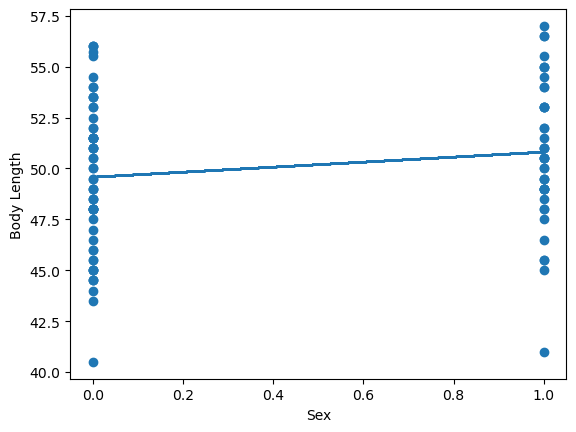

In [4]:
R2, b = multiRegFit(df, df["bodyL"], ["sexI"])
print(b)
plt.scatter(df["sexI"], df["bodyL"])
plt.plot(df["sexI"], multiRegPredict(b, df,["sexI"]))
plt.xlabel('Sex')
plt.ylabel('Body Length')


Figure 1. Scatter plot of regression analysis of bodyL against sexI. 0 is male, 1 is female. Blue line is representative of regression prediction 

### Question 1.2 (10pt)
Use boostrap to estimate a 95% confidence interval on the regression parameter of sex as a explanatory variable for body length. Report the confidence interval. Can you reject the null-hypothesis that body length in possums does not differ between the sexes?  

In [5]:
def confidenceInt(data, prec):
    bounds = []
    bounds.append(np.percentile(data, 100-prec))
    bounds.append(np.percentile(data, prec))
    
    return bounds

def bootstrap(df, y, fitfcn, numIter = 500, args=()):

    R2, b = fitfcn(df,y,args)

    numParam = len(b)
    
    N = len(df.index)
    ind = np.arange(N)

    stat = np.zeros((numIter, numParam))
    
    for i in range (0, numIter):
        sample = np.random.choice(ind, N, replace = True)
        
        r2, stat[i, :] = fitfcn(df.iloc[sample], y[sample], args)
        
    return stat

In [6]:
d = bootstrap(df, df["bodyL"], multiRegFit, numIter = 500, args = ["sexI"])
confidenceInt(d[:,1], 95)

[0.09992580615018357, 2.350774410774395]

The null hypothesis that body length in possums does not differ in sexes can be rejected as the confidence interval does not contain 0. This means there is at least some relationship between the variables.

### Question 1.3 (10pt)
Make a scatter plot of age (x-axis) against body length (y-axis), with male and female possums shown in different colors. 
You can do this by plotting two scatter plots sequentially - each time selecting either male or female possums. The second one will simply add points in a different color to the first plot.  

Estimate a multiple regression model that explains bodyL as a function of age and sex. What is the R2-value? 

Get the predicted values from the regression, and plot the predicted values in the same graph seperately for male and female possums. 

The R2 is 0.08543037213506455
The regression coeffs are [47.88904116  1.11817002  0.45140304]


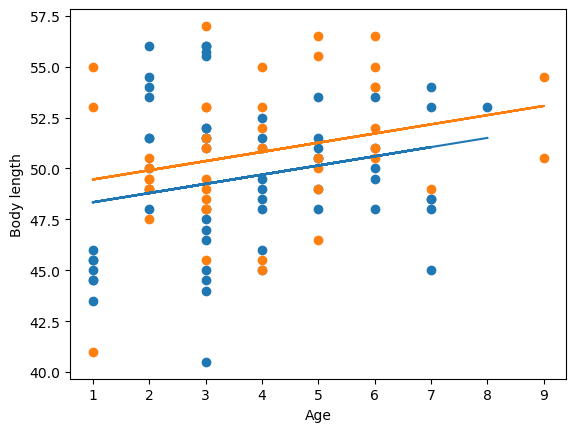

In [7]:
plt.scatter(df.age[df.sexI==0], df.bodyL[df.sexI==0])
plt.scatter(df.age[df.sexI==1], df.bodyL[df.sexI==1])

R2, b = multiRegFit(df, df["bodyL"], ["sexI", "age"])

yp = multiRegPredict(b, df,["sexI", "age"])
plt.plot(df.age[df.sexI==0], yp[df.sexI==0])
plt.plot(df.age[df.sexI==1], yp[df.sexI==1])
plt.xlabel('Age')
plt.ylabel('Body length')

print("The R2 is", R2)
print("The regression coeffs are", b)

Figure 2. A scatter plot of age against body length, with male possums in blue and female possums in orange. Lines are predicted values of the regression split by gender. 

### Question 1.4 (7pt)
Run a bootstrap analysis on the bodyL ~ age + sexI regression model. Report the 95% confidence interval for the regression parameters of sex and age on body length. How big is the effect of age onto body length in the context of the model? Does the confidence interval for the parameter include 0?


How big is the estimate of the effect of sex on body length? What is the CI? Does it include zero?   


In [8]:
d = bootstrap(df, df["bodyL"], multiRegFit, numIter = 500, args = ["sexI", "age"])
print("CI for effect of sex on body length", confidenceInt(d[:1], 95))
print("CI for effect of age on body length", confidenceInt(d[:2], 95))

CI for effect of sex on body length [0.33874793147137716, 43.81038421404334]
CI for effect of age on body length [0.30814035607490964, 48.46601796204631]


Both age and sex have an effect on body length. Neither parameters include 0 which means there is some relationship between the variables. Both CI's are very large suggesting impact of relationship is heavily varied. The influence is significant within the context of the model.

### Question 1.5 (10pt)
Estimate a multiple regression model that explains bodyL as a function of age and population (Vic vs. other). What is the R2-value? Make a scatter plot like for Question 3, but this time splitting the data for the two populations, rather than based on sex. 

Which of the two population (Vic or other) has a larger mean body size? What is the mean differences in body size?  

In contrast to simple mean difference in body size, how do you interpret the value of the regression coefficient for popI?  

The R2 is 0.1797451784949854
The regression coeffs are [47.3855543   2.47718803  0.41746659]


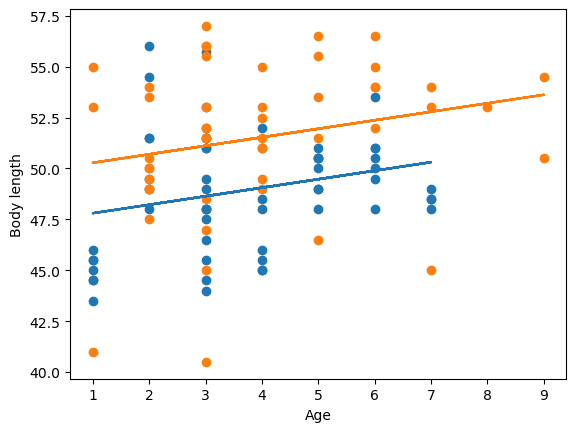

In [9]:
# 1 == vic (orange)
plt.scatter(df.age[df.popI==0], df.bodyL[df.popI==0])
plt.scatter(df.age[df.popI==1], df.bodyL[df.popI==1])

R2, b = multiRegFit(df, df["bodyL"], ["popI", "age"])

yp = multiRegPredict(b, df,["popI", "age"])
plt.plot(df.age[df.popI==0], yp[df.popI==0])
plt.plot(df.age[df.popI==1], yp[df.popI==1])
plt.xlabel('Age')
plt.ylabel('Body length')

print("The R2 is", R2)
print("The regression coeffs are", b)

Figure 3. A scatter plot of age against body length, with possums in population other in blue and vic possums in orange. Lines are predicted values of the regression split by population. 

In [10]:
bodysizeVic = df['bodyL'].groupby(df['popI']).get_group(1).mean()
bodysizeOther = df['bodyL'].groupby(df['popI']).get_group(0).mean()

print("The mean body size of possums in Vic is", bodysizeVic)
print("The mean body size of possums in other is", bodysizeOther)
print("The difference in body sizes is", abs(bodysizeVic-bodysizeOther))

The mean body size of possums in Vic is 51.53260869565217
The mean body size of possums in other is 48.925862068965515
The difference in body sizes is 2.6067466266866575


The value of popI's regression coefficient is very similar to the mean difference in body size (2.47 vs 2.60). However unlike mean, regression coefficients represent independent effect on the dependent variable after controlling for the impact of other independent variables. The regression coefficient is lower than the mean because it is being controlled, this means that something else, other than population, has an effect on size. The influence is significant within the context of the model.  

### Question 1.6 (8pt)
Run a bootstrap analysis on the bodyL ~ age + popI regression model. Report the 95% confidence interval for the regression parameters of popI and age on body length. In the conext of the model, is there evidence for a positive effect of age onto body length? How about the relationship between population and body length? 


In [11]:
d = bootstrap(df, df["bodyL"], multiRegFit, numIter = 500, args = ["popI", "age"])
print("CI for effect of popI on body length", confidenceInt(d[:1], 95))
print("CI for effect of age on body length", confidenceInt(d[:2], 95))

CI for effect of popI on body length [0.5169934122029574, 42.93536888214391]
CI for effect of age on body length [0.3789355784546714, 47.41210328465443]


There is evidence for a positive effect of both age and population on body length. Neither parameters include 0 which means there is some relationship between the variables. The CI for popI is more narrow than that of age.  

## Task 2: Discrete response variable
In this task we will investigate regression models in which the response variable is a discrete, dichotomous variable. 
### Question 2.1: Logistic Function (10pt)
Starting with your function for multRegPredict, write a function logisticRegPredict(b,D,xname). As inputs it should take the 
- b: np-array of regression coefficients (the first one being the intercept)
- D: Data frame
- xname: a list of column names (in D) that are being used as regressors. 

The function should first calculate a = b[0] + b[1] * D[xname[0]] + b[2] * D[xname[1]] 
and then return the logistic function of a. 

Then make a Data frame with a single column with the values from -4 to 4 (in small steps). Plot the logistic function for the parameter values: 
- b = [0,0]
- b = [0,1]
- b = [0,2]
- b = [0,-2]

What happens as the slope value changes? 

Then plot the logistic function for the parameter values: 
- b = [0,2]
- b = [1,2]
- b = [2,2]
- b = [-2,2]

What happens as the intercept value changes? For each value - where does the predicted line cross p=0.5? 



In [12]:
def logisticRegPredict(b, df, xname):
    # b      parameters
    # D      dataframe
    # xname  names of the explanatory variables
    
    # initialize the predicted array
    ## starting from the intercept
    an = np.ones(len(df.index)) * b[0]
    
    # get the predicted values
    for i in range(len(xname)):
        an = an + b[i + 1] * df[xname[i]]
        
    pn = 1 / (1 + np.exp(-an))
    
    return pn

In [13]:
# create a dataframe with values ranging from -1 to 1
entries = np.linspace(-4, 4, num = 50)

# put the array in a dataframe
Ef = pd.DataFrame(entries, columns = ['MyEntries'])

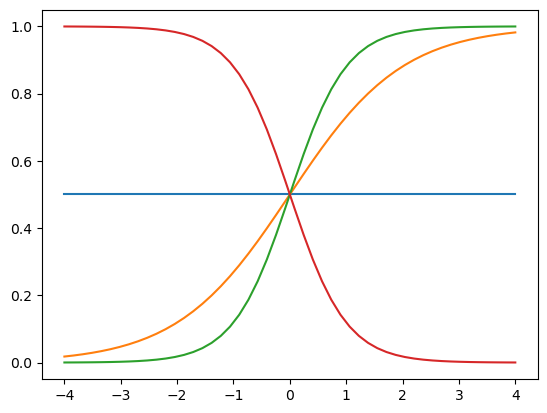

In [14]:
plt.plot(np.linspace(-4, 4), logisticRegPredict(b = [0,0], df = Ef, xname = ["MyEntries"]))
plt.plot(np.linspace(-4, 4),logisticRegPredict(b = [0,1], df = Ef, xname = ["MyEntries"]))
plt.plot(np.linspace(-4, 4),logisticRegPredict(b = [0,2], df = Ef, xname = ["MyEntries"]))
plt.plot(np.linspace(-4, 4),logisticRegPredict(b = [0,-2], df = Ef, xname = ["MyEntries"]))

Figure 4. Logistic regression using 50 values between -4 and 4. Regression was run for b = (0,0) in blue, b = (0,1) in orange, b = (0,2) in green, and b = (0,-2) in red.

As slope value moves away from 0 the function gets steeper. Sign of the coefficient is directly related to direction of slope (positive vs negative)

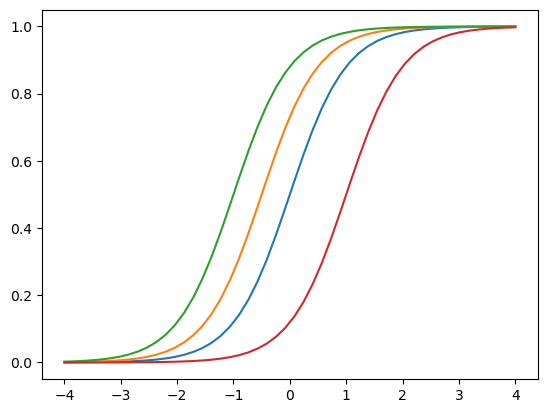

In [15]:
plt.plot(np.linspace(-4, 4),logisticRegPredict(b = [0,2], df = Ef, xname = ["MyEntries"]))
plt.plot(np.linspace(-4, 4),logisticRegPredict(b = [1,2], df = Ef, xname = ["MyEntries"]))
plt.plot(np.linspace(-4, 4),logisticRegPredict(b = [2,2], df = Ef, xname = ["MyEntries"]))
plt.plot(np.linspace(-4, 4),logisticRegPredict(b = [-2,2], df = Ef, xname = ["MyEntries"]))

Figure 5. Logistic regression using 50 values between -4 and 4. Regression was run for b = (0,2) in blue, b = (1,2) in orange, b = (2,2) in green, and b = (-2,2) in red.

As the intercept value increase the line begins to trend upwards earlier, as it decrease it takes longer for it to initially grow.   
For b = (0,2) the predicted line crosses at ~ 0  
For b = (1,2) the predicted line crosses at ~ -0.75  
For b = (2,2) the predicted line crosses at ~ -1.25  
For b = (-2,2) the predicted line crosses at ~ 1  

### Question 2.2 (10pt)
Make a Scatterplot of tail length (as a x-variable) against popI (Population, 1:Victoria 0:other). 
Written answer: What relationship can you see? 


Text(0, 0.5, 'Population')

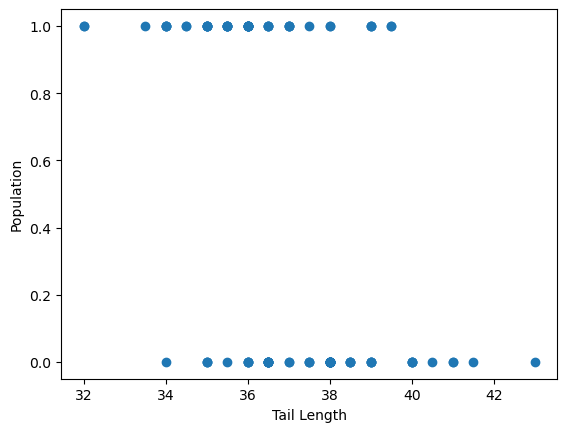

In [16]:
plt.scatter(df["tailL"], df["popI"]) #== 1) # vic
#plt.scatter(df["tailL"], df["popI"] == 0) #other
plt.xlabel('Tail Length')
plt.ylabel('Population')

Figure 6. Scatter plot of tail length and location. 1 is Vic and 0 is other.

Population in Vic seem to tend to shorter tail lengths where's other populations seem to have a larger tail length

### Question 2.3 (10pt)
Write a function logisticRegLoss(b,D,y,name) that calculates the Loss function for the logistic regression (negative log-likelihood, see lecture). The function should call logisticRegPredict to get the prediction, and then calculate the Loss and the derivative of the loss in respect to all regression paramaters. The function should be able to use multiple regressors (like multRegLossRSS from previous homeworks).    

Report the negative log likelihood (and derivates) for a logistic regression model that predicts popI as a function of tailL: 
- for the parameter values [0,0]
- for the parameter values [17.5,-0.5]
- for the parameter values [25.56,-0.7]

Which one is the best parameter setting of the three? 

In [17]:
def logisticRegLoss(b, df, y, xname):
    # 1. use the prediction function
    pn = logisticRegPredict(b, df, xname)

    # 2. get the cost:
    ## tep by step implementation
    A = y*np.log(pn)
    B = (1-y)
    C = np.log(1 - pn)

    ## now look at the formula and implement it using A, B, C
    
    L = -1 * sum(A + B * C)

    # 3. get the derivatives array
    ## initialize with the value for intercept:
    deriv = np.zeros(len(xname)+1)
    res = y - pn
    
    deriv[0] = -sum(res) 

    ## now loop over and get the grad
    for i in range(len(xname)):
        deriv[i+1]=-np.sum(df[xname[i]]*res)
        
    return L, deriv


In [18]:
L, deriv = logisticRegLoss([0,0], df, df["popI"], ["tailL"])
print("Loss:\n", L)
print("Derivs: ", deriv)
L, deriv = logisticRegLoss([17.5,-0.5], df, df["popI"], ["tailL"])
print("Loss:\n", L)
print("Derivs: ", deriv)
L, deriv = logisticRegLoss([25.56,-0.7], df, df["popI"], ["tailL"])
print("Loss:\n", L)
print("Derivs: ", deriv)

Loss:
 72.08730677823438
Derivs:  [  6.  271.5]
Loss:
 63.01497836859202
Derivs:  [ -14.65999642 -527.46450906]
Loss:
 56.72412770882332
Derivs:  [ -0.37160079 -13.678462  ]


The best parameters setting is [25.56, -0.7] because the derivitives are closest to 0 and the loss is minimized. 

### Question 2.4 (10pt)
Write a function logisticRegFit(D,y,xname,figure=True) that fits the logistic model by minimizing the above Loss function. 
- D: A data frame with the explanatory variables 
- y: A dichotomous (0 or 1) response variable 
- xname: Names of x variables to be used 
- figure: Flag (True / False) indicating if the code should produce a figure. 
When there is only one x-variable, and figure==True, then function should produce a scatter plot of the data and the predicted values. 

The function should return the log-likelihood of the data under the best model and the best fitting (maximum liklihood) estimates of b. Remember that the function value you are minimizing is the *negative* log-likelihood, and the best fitting value is stored in RES.fun

Fit a logistic regression model that predicts popI as a function of tailL. Make sure the function generates a plot. Report log-likelihood and b-values. 

In [19]:
def logisticRegFit(df, y, xname, figure = True):
    N = len(xname)
    b0 = np.zeros(N+1)
    
    result = so.minimize(logisticRegLoss,b0,args=(df,y,xname),jac=True)
    
    b = result.x
    ll = -result.fun
    
    if (N == 1) & (figure ==True):
        plt.scatter(df[xname], y) 
        
        mini, maxi = min(df[xname[0]]), max(df[xname[0]])
        xp = np.arange(mini, maxi, (maxi - mini)/100)
        yp = b[1]*xp + b[0]
        pn = np.exp(yp)/(1+np.exp(yp))
        plt.plot(xp, pn, 'r-')
    
    
    return ll, b


Log-likelihood -56.720515795441194
B-values [25.56620498 -0.69964063]


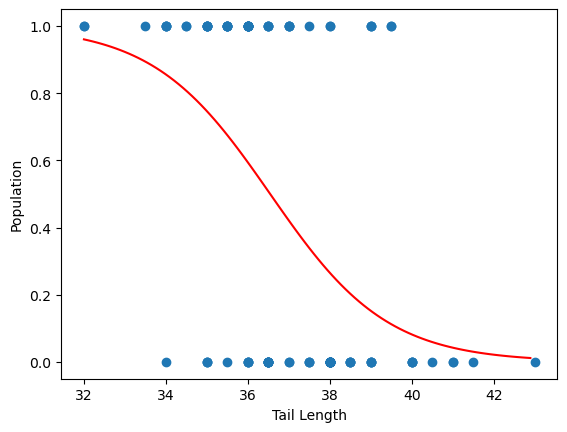

In [20]:
ll, b = logisticRegFit(df, df["popI"], ["tailL"], figure = True)
plt.xlabel('Tail Length')
plt.ylabel('Population')
print("Log-likelihood", ll)
print("B-values", b)

Figure 7. Tail length by population locations. 1 is Vic and 0 is other. Red line is best fit logistic regression.

### Question 2.5 (10pt)
Now fit the model explaing popI from tailL and bodyL in a multiple logistic regression model. Report the log-likelihood and parameter values. Is the fit better than tailL alone? 

Also fit the model explaing popI from tailL and totalL in a multiple logistic regression model. Again, report the log-likelihood and parameter values. 

What do you observe in terms of log-likelihood and in terms of paramters? Why do these two models yield exactly the same log-liklihood? 

In [21]:
ll, b = logisticRegFit(df, df["popI"], ["tailL", "bodyL"], figure = False)
print("Log-likelihood", ll)
print("B-values", b)

Log-likelihood -43.20463551583584
B-values [16.57735312 -0.98846114  0.39180167]


The fit is better than tail alone as the log likelihood increases and the b-values get closer to 0. 

In [22]:
ll, b = logisticRegFit(df, df["popI"], ["tailL", "totalL"], figure = False)
print("Log-likelihood", ll)
print("B-values", b)

Log-likelihood -43.204635515835854
B-values [16.57735311 -1.38026281  0.39180167]


The log-likelihoods are the same as one is looking at tail length and body length, which makes up total length. So in the second model tail length would be accounted for twice but is not because of the regression. This is why the b-value for tail length is lower in the second model, it must be accounted for. 